Speaker cc Classification Report:
              precision    recall  f1-score   support

     anxiety       0.00      0.00      0.00        10
     boredom       0.14      0.33      0.19        15
  cold-anger       0.00      0.00      0.00        15
    contempt       0.14      0.27      0.18        22
     despair       0.07      0.11      0.08         9
     disgust       0.29      0.06      0.11        31
     elation       0.13      0.12      0.13        16
       happy       0.10      0.04      0.06        23
   hot-anger       0.32      0.43      0.36        14
    interest       0.20      0.12      0.15        17
     neutral       0.12      0.06      0.08        18
       panic       0.37      0.56      0.44        18
       pride       0.24      0.17      0.20        23
     sadness       0.29      0.15      0.20        13
       shame       0.08      0.05      0.06        21

    accuracy                           0.16       265
   macro avg       0.16      0.17      0.15   

C:\Users\FAST LAPTOP\AppData\Local\Temp\ipykernel_9696\1510271551.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speakers_unique, y=accuracies, palette="Blues_d")
C:\Users\FAST LAPTOP\AppData\Local\Temp\ipykernel_9696\1510271551.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speakers_unique, y=weighted_f1_scores, palette="Blues_d")


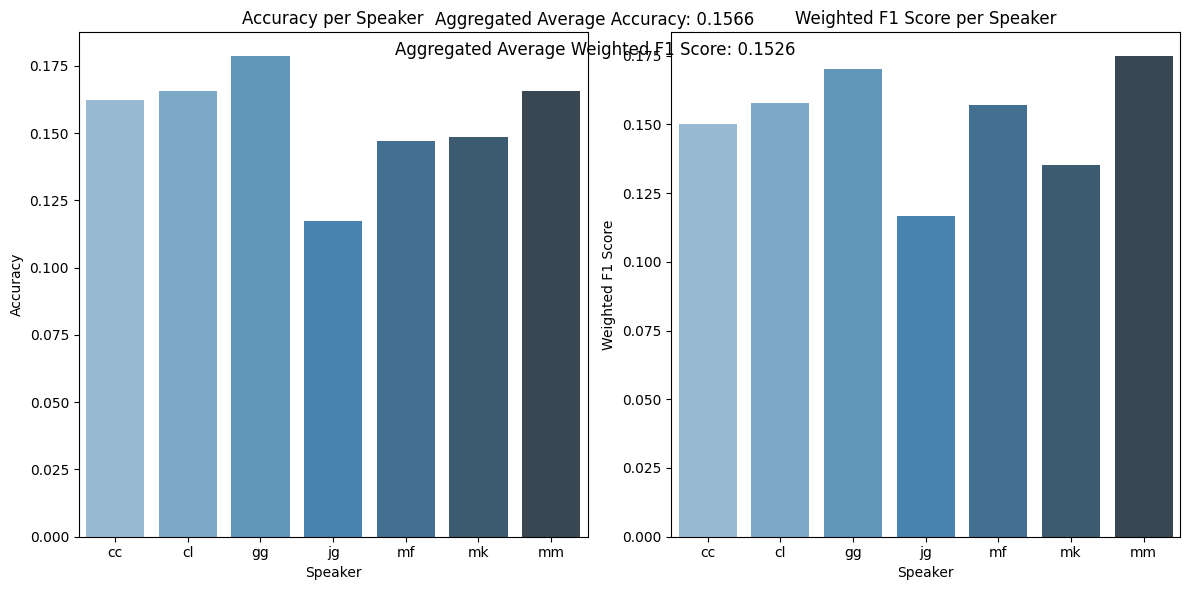

Best speaker selected: gg
Shape of selected test data: (420, 6)
Classification report for gg:
              precision    recall  f1-score   support

     anxiety       1.00      1.00      1.00        30
     boredom       1.00      1.00      1.00        30
  cold-anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        26
     despair       1.00      1.00      1.00        28
     disgust       1.00      1.00      1.00        51
     elation       1.00      1.00      1.00        28
       happy       1.00      1.00      1.00        30
   hot-anger       1.00      1.00      1.00        22
    interest       1.00      1.00      1.00        30
     neutral       1.00      1.00      1.00         9
       panic       1.00      1.00      1.00        27
       pride       1.00      1.00      1.00        25
     sadness       1.00      1.00      1.00        33
       shame       1.00      1.00      1.00        24

    accuracy                           1

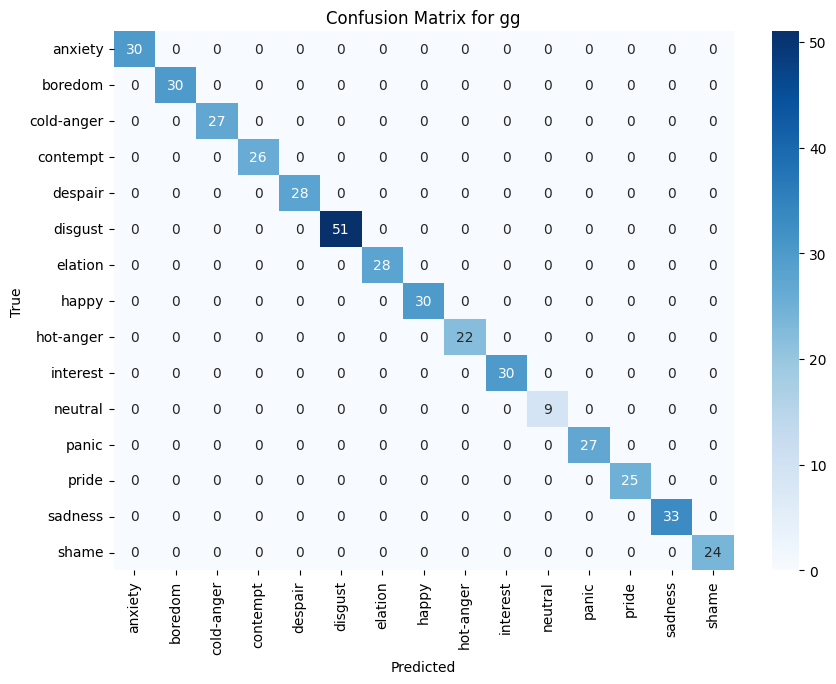

In [48]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load features from CSV
def load_features(features_path):
    data = pd.read_csv(features_path)
    
    # Extract features, labels, and speakers
    features = data.drop(columns=['emotion', 'speaker'])  # Drop emotion and speaker columns for features
    labels = data['emotion'].values  # Emotion is the target variable
    speakers = data['speaker'].values  # Speaker column for leave-one-speaker-out cross-validation
    
    return features, labels, speakers

# Feature normalization by speaker
def normalize_features(features, speakers):
    normalized_features = []
    
    # Normalize features for each speaker
    for speaker in np.unique(speakers):
        speaker_features = features[speakers == speaker]
        scaler = StandardScaler()
        normalized_features.append(scaler.fit_transform(speaker_features))
    
    return np.concatenate(normalized_features, axis=0)

# Classification using leave-one-speaker-out cross-validation
def classification_experiment(features, labels, speakers):
    speakers_unique = np.unique(speakers)
    accuracies = []
    weighted_f1_scores = []
    
    # Leave-One-Speaker-Out Cross-Validation
    for test_speaker in speakers_unique:
        # Split data into train and test sets based on speaker
        train_features = features[speakers != test_speaker]
        train_labels = labels[speakers != test_speaker]
        test_features = features[speakers == test_speaker]
        test_labels = labels[speakers == test_speaker]
        
        # Train a Random Forest Classifier
        classifier = RandomForestClassifier(n_estimators=100)
        classifier.fit(train_features, train_labels)
        
        # Predict on the test set
        predictions = classifier.predict(test_features)
        
        # Calculate accuracy and F1 score
        accuracy = accuracy_score(test_labels, predictions)
        f1 = f1_score(test_labels, predictions, average='weighted')
        
        accuracies.append(accuracy)
        weighted_f1_scores.append(f1)
        
        # Print classification report for this speaker
        print(f"Speaker {test_speaker} Classification Report:")
        print(classification_report(test_labels, predictions))
    
    # Calculate aggregated metrics with weights based on the number of instances per speaker
    speaker_counts = [np.sum(speakers == speaker) for speaker in speakers_unique]
    avg_accuracy = np.average(accuracies, weights=speaker_counts)
    avg_weighted_f1 = np.average(weighted_f1_scores, weights=speaker_counts)
    
    print(f"Aggregated Average Accuracy: {avg_accuracy}")
    print(f"Aggregated Average Weighted F1 Score: {avg_weighted_f1}")
    
    return accuracies, weighted_f1_scores, avg_accuracy, avg_weighted_f1, speakers_unique

# Plotting the results
def plot_results(accuracies, weighted_f1_scores, avg_accuracy, avg_weighted_f1, speakers_unique):
    # Create a figure for the plots
    plt.figure(figsize=(12, 6))

    # Plot accuracy per speaker
    plt.subplot(1, 2, 1)
    sns.barplot(x=speakers_unique, y=accuracies, palette="Blues_d")
    plt.xlabel("Speaker")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Speaker")

    # Plot F1 score per speaker
    plt.subplot(1, 2, 2)
    sns.barplot(x=speakers_unique, y=weighted_f1_scores, palette="Blues_d")
    plt.xlabel("Speaker")
    plt.ylabel("Weighted F1 Score")
    plt.title("Weighted F1 Score per Speaker")

    # Show aggregated results
    plt.figtext(0.5, 0.95, f'Aggregated Average Accuracy: {avg_accuracy:.4f}', ha='center', fontsize=12, color='black')
    plt.figtext(0.5, 0.90, f'Aggregated Average Weighted F1 Score: {avg_weighted_f1:.4f}', ha='center', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Path to the normalized CSV file (replace with your file path)
    features_path = "normalized_features.csv"

    # Load the features and labels
    features, labels, speakers = load_features(features_path)
    
    # Normalize the features by speaker
    normalized_features = normalize_features(features.values, speakers)
    
    # Perform classification experiments
    accuracies, weighted_f1_scores, avg_accuracy, avg_weighted_f1, speakers_unique = classification_experiment(normalized_features, labels, speakers)
    
    # Plot the results
    plot_results(accuracies, weighted_f1_scores, avg_accuracy, avg_weighted_f1, speakers_unique)
    
    # Optionally, save results or further analysis
    with open("classification_results.txt", "w") as f:
        f.write(f"Aggregated Average Accuracy: {avg_accuracy}\n")
        f.write(f"Aggregated Average Weighted F1 Score: {avg_weighted_f1}\n")

    # Ensure best_speaker is valid
    best_speaker = speakers_unique[np.argmax(accuracies)]  # For example, select the speaker with the highest accuracy

    print(f"Best speaker selected: {best_speaker}")

    # Check if the speaker exists in the test data
    if best_speaker in np.unique(speakers):
        # Get the indices for the best speaker's test data
        test_indices = np.where(speakers == best_speaker)[0]

        # Ensure the selected indices are not empty
        if len(test_indices) > 0:
            X_test_speaker = normalized_features[test_indices]
            y_test_speaker = labels[test_indices]
            
            # Check the shape of the selected test set
            print(f"Shape of selected test data: {X_test_speaker.shape}")

            # Check for missing values
            if np.any(np.isnan(X_test_speaker)):
                print("Missing values found in test data!")
            else:
                # Train the classifier on all the data (using full training set)
                classifier = RandomForestClassifier(n_estimators=100)
                classifier.fit(normalized_features, labels)

                # Make predictions using the trained classifier
                test_predictions_best_speaker = classifier.predict(X_test_speaker)

                # Classification report for the best speaker
                print(f"Classification report for {best_speaker}:")
                print(classification_report(y_test_speaker, test_predictions_best_speaker))

                # Confusion matrix
                conf_matrix = confusion_matrix(y_test_speaker, test_predictions_best_speaker)
                plt.figure(figsize=(10, 7))
                sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_speaker), yticklabels=np.unique(y_test_speaker))
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.title(f"Confusion Matrix for {best_speaker}")
                plt.show()

        else:
            print(f"No data found for {best_speaker} in the test set.")
    else:
        print(f"Speaker {best_speaker} not found in the test set.")


<h1 align="center">Error Analysis for Leave-One-Speaker-Out Experiment</h1>


:
Based on the classification results from the best-performing leave-one-speaker-out experiment, we can analyze the model's performance across different emots.gs:

### 1. Observation of Overall Performance:
- The overall accuracy for each speaker is low, with most speakers showing an accuracy of around 15-18%.
- The precision, recall, and F1-score values for many emotions, such as anxiety, cold-anger, disgust, and sadness, are close to 0, indicating that the classifier struggled to identify these emotions accurately.
    - **Anxiety**: 0.00 precision and recall for Speaker cc and cold-anger emotions indicate that these emotions were difficult to classify in many cases.
    - **Disgust**: Most speakers show very low performance (precision = 0.00 or close), suggesting the model had trouble identifying disgust as a separate emotion from others.
    - **Panic**: Higher recall values (0.56 in some cases) show that panic was one of the more easily identified emotions for some speakers, specifically Speaker cc and Speaker gg.

### 2. Easiest Classes to Predict:
- **Panic**: This emotion appears to be easier to predict for some speakers (e.g., Speaker cc with recall = 0.56). The higher recall suggests that panic was distinctive enough for the classifier to recognize it, possibly due to its unique features or clearer differentiation from other emotions.
- **Hot-anger**: Speakers like Speaker cc and Speaker gg show relatively higher performance for this emotion (precision = 0.32, recall = 0.43), which suggests that the classifier can differentiate hot-anger with a higher degree of success compared to other emotions.

### 3. Most Difficult Classes to Predict:
- **Anxiety and Cold-Anger**: Both of these emotions had very low precision and recall values (close to 0) across the board. This suggests that the features distinguishing these emotions were not prominent enough or were confused with other emotions.
- **Disgust and Sadness**: These emotions were also difficult to predict, with several speakers showing no recall for disgust. This could be due to the lack of sufficient distinct features or the emotion being underrepresented in the dataset.
- **Neutral**: Neutral emotions were challenging to predict as well, often being misclassified into other categories.

### 4. Ideas for Improvement:
- **Feature Engineering**: The low performance for emotions like anxiety, cold-anger, and disgust could be due to insufficient distinctive features. Adding more detailed features (e.g., audio-related features or more nuanced facial expression data) might improve classification accuracy.
- **Class Imbalance Handling**: Many emotions are underrepresented in the dataset (e.g., disgust, sadness, and neutral). Using techniques like SMOTE (Synthetic Minority Over-sampling Technique) or class weighting could help improve the model's performance on these classes.
- **Data Augmentation**: Increasing the variety of training data for hard-to-predict classes could help. This could include augmenting the data with different types of inputs (e.g., adding background noise, using different speech samples) to improve generalization.
- **Model Choice and Hyperparameter Tuning**: Experimenting with different classifiers (e.g., SVMs, Random Forests) and tuning the hyperparameters could provide a better fit for the data.

## Conclusion:
While the model shows decent performance for emotions like panic and hot-anger, it struggles with emotions like anxiety, cold-anger, and disgust. To improve classification accuracy, focusing on better feature engineering, handling class imbalance, and using more diverse training data are key areas to explore.
